# Benchmark Analysis

This notebook isn't complete and cells weren't run the one after the other. Be carefull of any generated graph if you don't fully understand what cells you ran. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def plot_execution_times(df, title='Execution Time vs N for Each Program'):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='N', y='exec_time_ns', hue='program_name', marker='o')
    plt.xlabel('N')
    plt.ylabel('Execution Time (ns)')
    plt.title(title)
    plt.legend(title='Program')
    plt.show()

In [6]:
df = pd.read_csv('ex01/resultssmall.csv')

In [8]:
df['program_name'] = df.apply(
    lambda row: f"omp_{row['num_procs']}" if row['program_name'] == 'omp'
    else (f"mpi_{row['num_procs']}" if row['program_name'] == 'mpi_sum' else row['program_name']),
    axis=1
)

In [9]:
df.to_csv('ex01/resultssmall.csv', index=False)

In [18]:
df = pd.read_csv('ex01/resultssmall.csv')

In [30]:
def remove_outliers(df):
    df_sorted = df.sort_values(['program_name', 'num_procs', 'N']).reset_index(drop=True)
    mask = np.ones(len(df_sorted), dtype=bool)

    for prog in df_sorted['program_name'].unique():
        for proc in df_sorted[df_sorted['program_name'] == prog]['num_procs'].unique():
            idx = df_sorted[(df_sorted['program_name'] == prog) & (df_sorted['num_procs'] == proc)].index
            times = df_sorted.loc[idx, 'exec_time_ns'].values
            for i, ix in enumerate(idx):
                neighbors = []
                for j in range(max(0, i-2), min(len(times), i+3)):
                    if j != i:
                        neighbors.append(times[j])
                if len(neighbors) >= 2:
                    mean_neighbors = np.mean(neighbors)
                    if times[i] > 2 * mean_neighbors:
                        mask[ix] = False
    return df_sorted[mask].reset_index(drop=True)

df = remove_outliers(df)

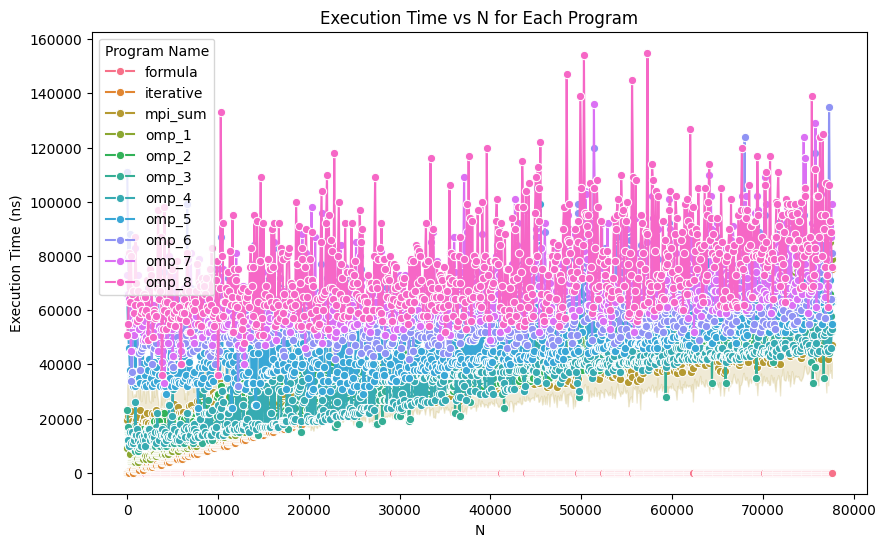

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N', y='exec_time_ns', hue='program_name', marker='o')
plt.xlabel('N')
plt.ylabel('Execution Time (ns)')
plt.title('Execution Time vs N for Each Program')
plt.legend(title='Program Name')
plt.show()

In [33]:
df_ = df[df["program_name"].isin(['iterative','omp_2', 'mpi_2', 'omp_8', "mpi_8"])]
df_ = df_[df_["N"]>=60000]
df_ = df_[df_["N"]<=700000]
i = 3  # taille de la fenêtre pour la moyenne glissante
df_ = df_.sort_values('N')
df_['exec_time_ns_smooth'] = df_['exec_time_ns'].rolling(window=i, center=True).mean()

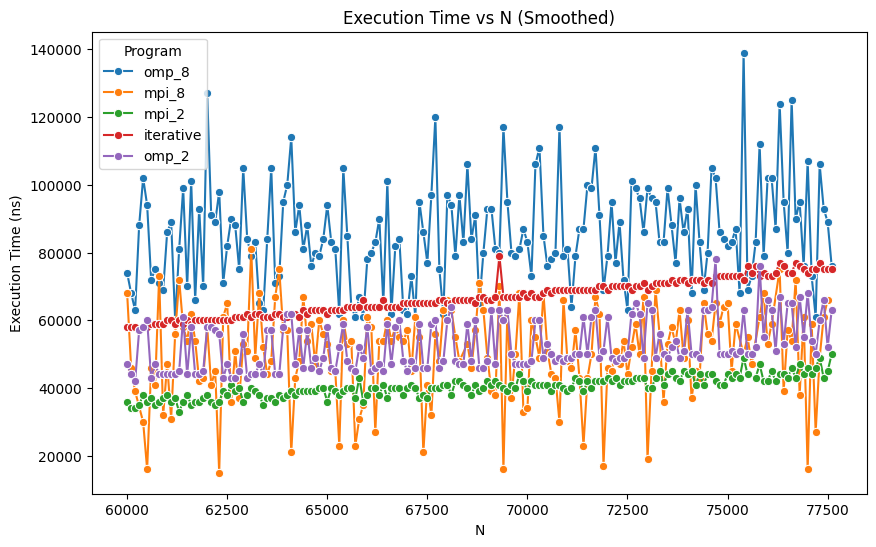

In [34]:
plot_execution_times(df_, title = 'Execution Time vs N (Smoothed)')


In [ ]:
df_ = df[df["program_name"].isin(['iterative', 'mpi_2', "mpi_5", "omp_2", "omp_5"])]
df_ = df_[df_["N"]<=100000]
i = 3  # taille de la fenêtre pour la moyenne glissante
df_ = df_.sort_values('N')
df_['exec_time_ns_smooth'] = df_['exec_time_ns'].rolling(window=i, center=True).mean()
plot_execution_times(df_, title = 'Execution Time vs N (Smoothed)')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [17]:
df = pd.read_csv('ex01/resultsvf.csv')

In [23]:
df['program_name'] = df.apply(
    lambda row: f"omp_{row['num_procs']}" if row['program_name'] == 'omp'
    else (f"mpi_{row['num_procs']}" if row['program_name'] == 'mpi_sum' else row['program_name']),
    axis=1
)

In [24]:
df.to_csv('ex01/resultsvf.csv', index=False)

In [35]:
df = pd.read_csv('ex01/resultsvf.csv')

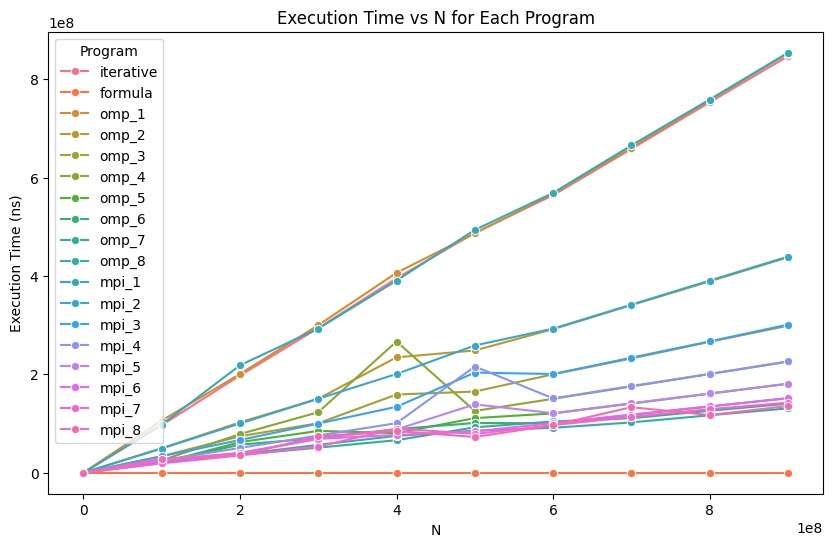

In [36]:
plot_execution_times(df)

In [37]:
def plot_execution_times_log(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='N', y='exec_time_ns', hue='program_name', marker='o')
    plt.xlabel('N')
    plt.ylabel('Execution Time (ns)')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Execution Time (Log-Log Scale)')
    plt.legend(title='Program Name')
    plt.show()

C:\Users\romai\AppData\Local\Temp\ipykernel_18968\123019565.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub[df["N"]!=1]


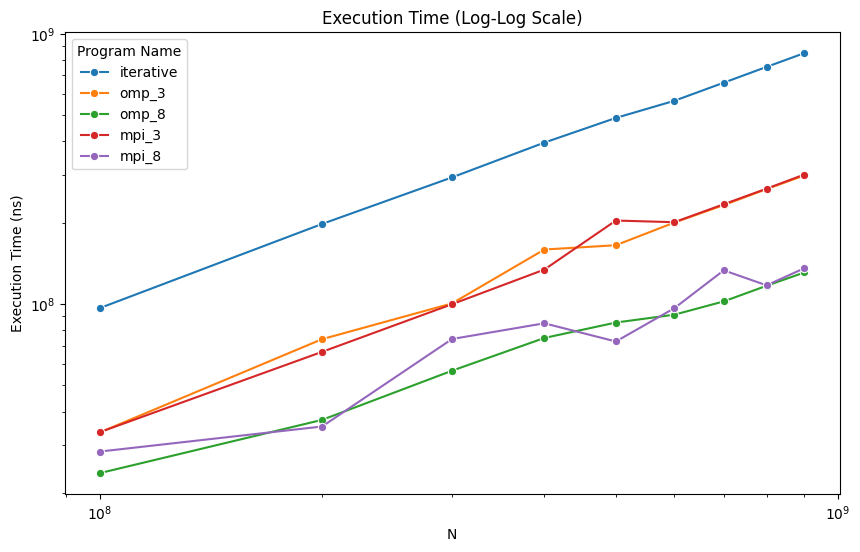

In [39]:
df_sub = df[df["program_name"].isin(["omp_3", "mpi_3", "omp_8", "mpi_8","iterative"])]
df_sub = df_sub[df["N"]!=1]
plot_execution_times_log(df_sub)

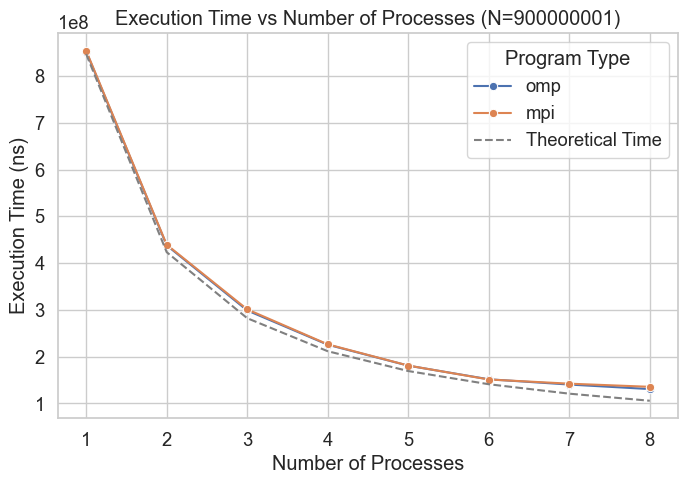

In [114]:
n = 900000001
iterative_t = df[df["program_name"] == "iterative"]
iterative_t = iterative_t[iterative_t["N"] == n]
iterative_t = iterative_t["exec_time_ns"].iloc[0]
theoretical_exec_time = [iterative_t/i for i in range(1,9)]

filtered_df = df[~df["program_name"].isin(["iterative", "formula"])]
filtered_df = filtered_df[filtered_df["N"] == n]

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=filtered_df,
    x='num_procs',
    y='exec_time_ns',
    hue=filtered_df['program_name'].apply(lambda x: 'omp' if x.startswith('omp') else ('mpi' if x.startswith('mpi') else x)),
    marker='o'
)
plt.plot(range(1, 9), theoretical_exec_time, '--', color='gray', label='Theoretical Time')
plt.xlabel('Number of Processes')
plt.ylabel('Execution Time (ns)')
plt.title(f'Execution Time vs Number of Processes (N={n})')
plt.legend(title='Program Type')
plt.show()

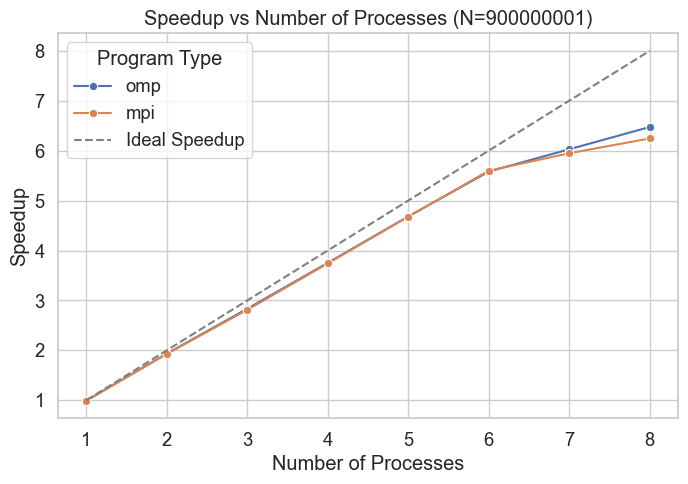

In [115]:
# Calculate speedup for each program (omp and mpi) compared to iterative_t
filtered_df = df[~df["program_name"].isin(["iterative", "formula"])]
filtered_df = filtered_df[filtered_df["N"] == n]

# Calculate speedup
filtered_df = filtered_df.copy()
filtered_df["speedup"] = iterative_t / filtered_df["exec_time_ns"]

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=filtered_df,
    x='num_procs',
    y='speedup',
    hue=filtered_df['program_name'].apply(lambda x: 'omp' if x.startswith('omp') else ('mpi' if x.startswith('mpi') else x)),
    marker='o'
)
plt.plot(range(1, 9), range(1, 9), '--', color='gray', label='Ideal Speedup')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup')
plt.title(f'Speedup vs Number of Processes (N={n})')
plt.legend(title='Program Type')
plt.show()
